In [8]:
import backtrader as bt
import pandas as pd
import akshare as ak
from backtrader.feeds import PandasData
from datetime import datetime as dt
import warnings
import quantstats as qs
warnings.filterwarnings('ignore')

In [9]:
fund_etf_hist_em_df = ak.fund_etf_hist_em(symbol="159915", period="daily", start_date="20200101", end_date="20240801", adjust="hfq")
fund_etf_hist_em_df['date'] = pd.to_datetime(fund_etf_hist_em_df["日期"])
fund_etf_hist_em_df.iloc[:, 2]

0       1.765
1       1.764
2       1.788
3       1.822
4       1.792
        ...  
1105    1.627
1106    1.604
1107    1.601
1108    1.658
1109    1.636
Name: 收盘, Length: 1110, dtype: float64

In [10]:
class SmaCross(bt.Strategy):
    # 可配置参数
    params = dict(
        pfast=10,      # 短周期：10日
        pslow=30,      # 长周期：30日
        printlog=False # 打印交易日志
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # 短周期均线
        sma2 = bt.ind.SMA(period=self.p.pslow)  # 长周期均线
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # 穿越信号
    
    #交易记录日志（默认不打印结果）
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()},{txt}')
    
    #记录交易执行情况（默认不输出结果）
    def notify_order(self, order):
        # 如果order为submitted/accepted,返回空
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果order为buy/sell executed,报告价格结果
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log(f'买入: 价格:{order.executed.price}, 成本:{order.executed.value}, 手续费:{order.executed.comm}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'卖出: 价格：{order.executed.price}, 成本: {order.executed.value}, 手续费{order.executed.comm}')
            self.bar_executed = len(self) 
        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失败')
        self.order = None

    #记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'收益：毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')

    def next(self):
        if not self.position:  # 未持仓
            total_value = self.broker.getvalue()
            #1手=100股，满仓买入
            sz = int((total_value/100)/self.datas[0].close[0])*100
            if self.crossover > 0:  # 向上穿
                self.buy(size=sz)  # 买入
        elif self.crossover < 0:  # 持仓遇到下穿
            self.close()  # 卖出

In [11]:
cerebro = bt.Cerebro()  # 创建Cerebro实例
data = PandasData(dataname=fund_etf_hist_em_df, 
                  datetime=11,
                  open=1,
                  high=3, 
                  low=4, 
                  close=2, 
                  volume=5, 
                  openinterest=-1)
cerebro.adddata(data) 

In [12]:
startcash = 20000
cerebro.addstrategy(SmaCross)

# 设置资金
cerebro.broker.setcash(startcash)
# 佣金
cerebro.broker.setcommission(commission=0.0001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="PyFolio")
results = cerebro.run()


In [13]:

#获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash
#打印结果
print(f'初始资金：{startcash}')
print(f'总资金: {round(portvalue,2)}')
print(f'净收益: {round(pnl,2)}')

初始资金：20000
总资金: 29538.47
净收益: 9538.47


                           Strategy
-------------------------  ----------
Start Period               2020-01-02
End Period                 2024-08-01
Risk-Free Rate             0.0%
Time in Market             43.0%

Cumulative Return          47.69%
CAGR﹪                     6.05%

Sharpe                     0.61
Prob. Sharpe Ratio         90.17%
Smart Sharpe               0.6
Sortino                    0.93
Smart Sortino              0.91
Sortino/√2                 0.66
Smart Sortino/√2           0.64
Omega                      1.17

Max Drawdown               -28.98%
Longest DD Days            756
Volatility (ann.)          16.7%
Calmar                     0.21
Skew                       0.22
Kurtosis                   6.19

Expected Daily %           0.04%
Expected Monthly %         0.7%
Expected Yearly %          8.11%
Kelly Criterion            7.17%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.69%
Expected Shortfall (cVaR)  -1.69%

Max Consecutive Wins       8
Ma

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-07-08,2023-11-29,2024-08-01,756,-28.980743,-28.710717
2,2021-02-18,2021-04-12,2021-05-28,100,-16.380973,-15.688793
3,2020-07-14,2020-10-23,2021-01-06,177,-14.652636,-14.045108
4,2021-07-22,2021-07-27,2022-06-01,315,-9.036882,-7.253941
5,2021-01-26,2021-01-29,2021-02-09,15,-6.531362,-5.703443


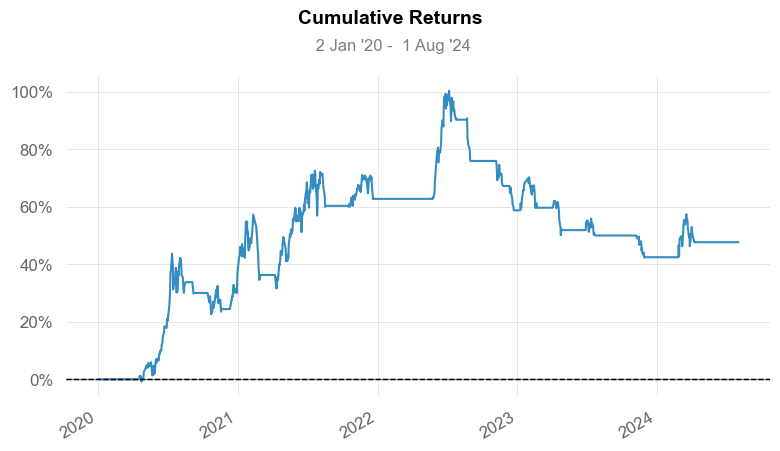

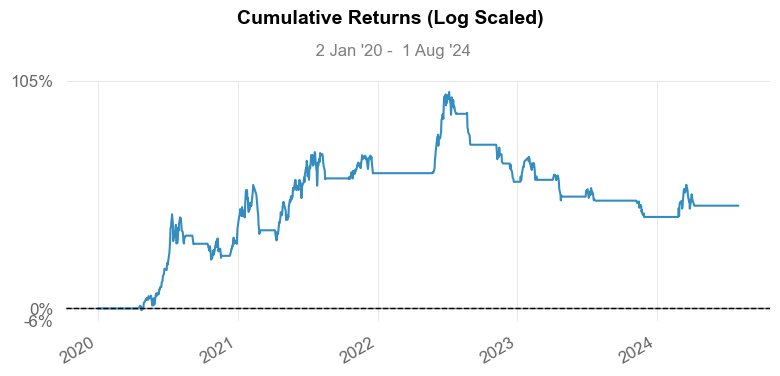

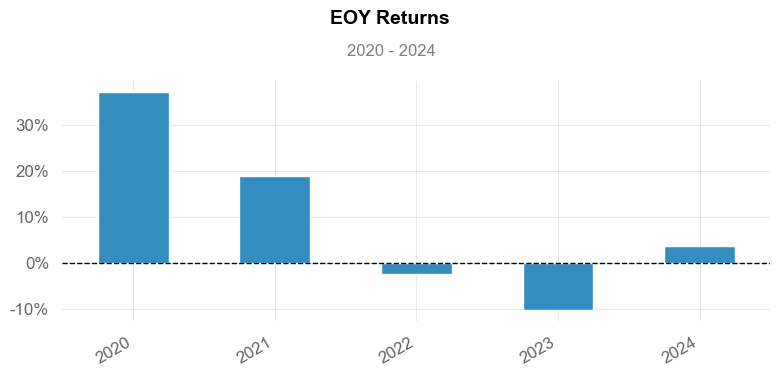

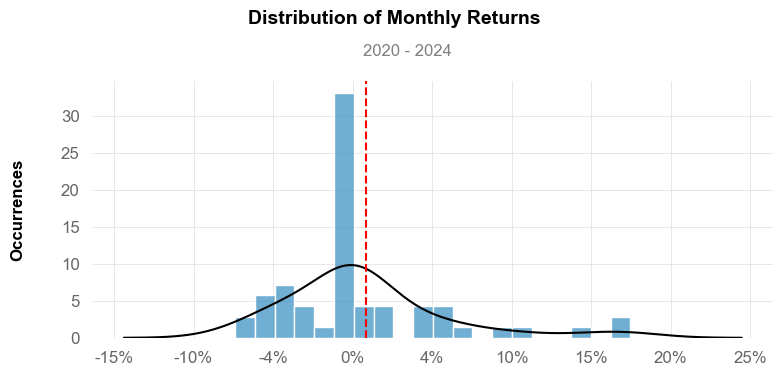

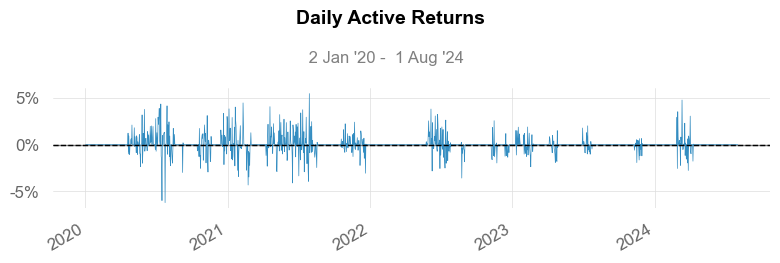

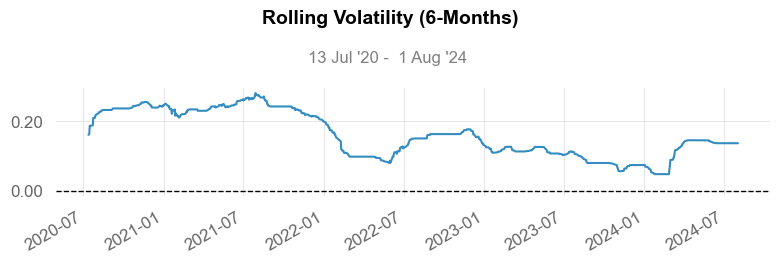

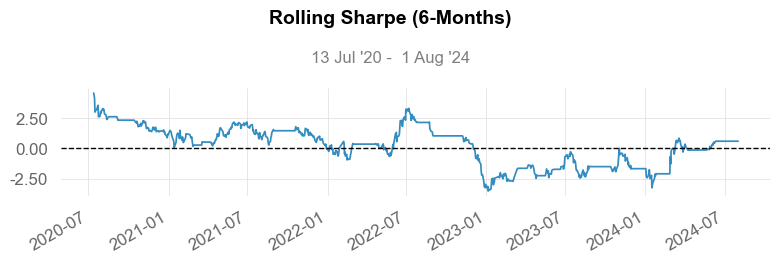

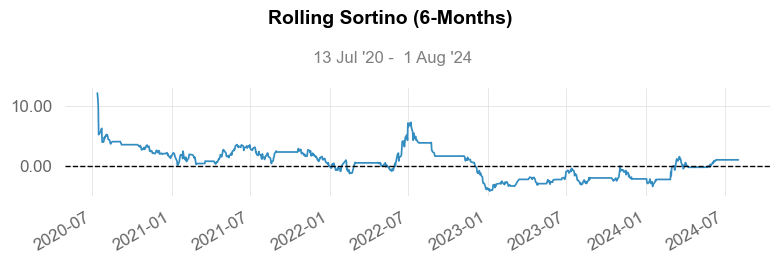

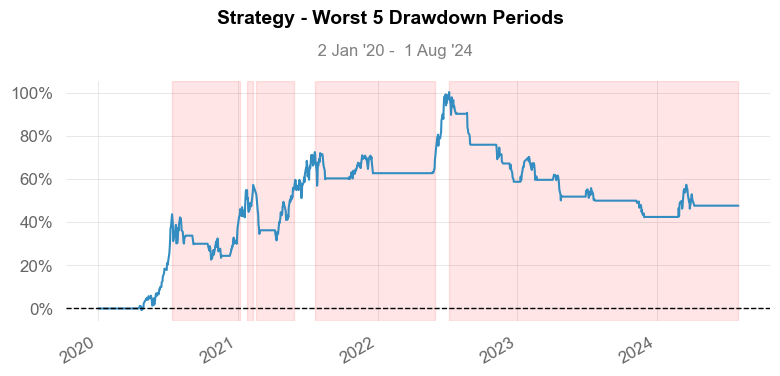

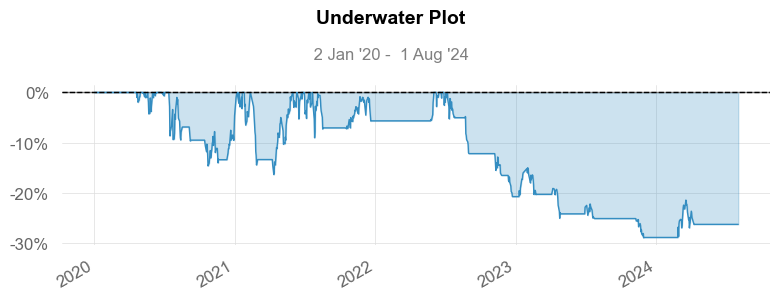

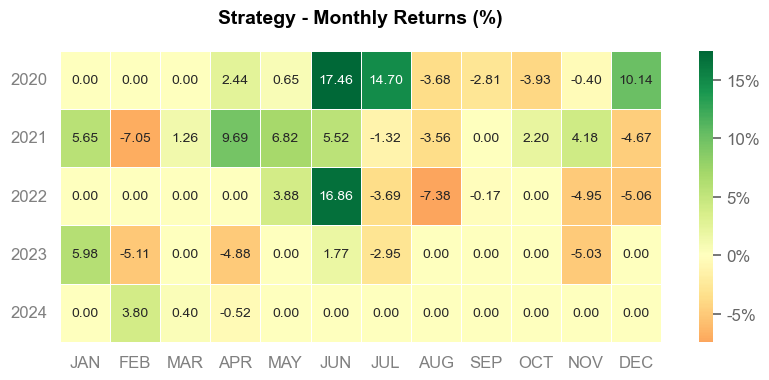

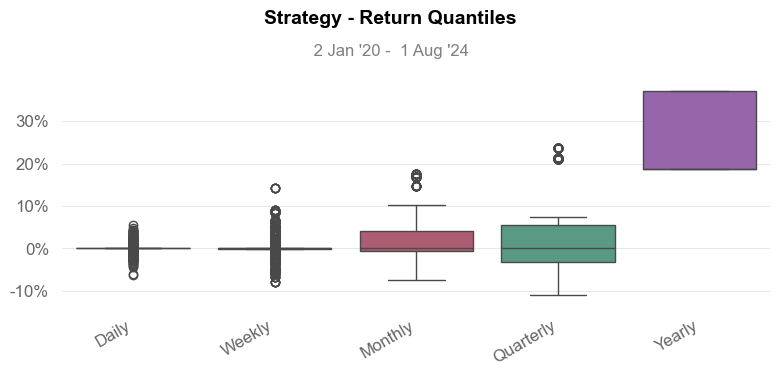

In [14]:
pyfolio = results[0].analyzers.PyFolio 
returns, positions, transactions, gross_lev = pyfolio.get_pf_items()
qs.reports.full(returns)